# 2024 March Madness

Notebook to compare Nate Silver's model predictions vs Bovada betting odds.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
import requests
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from tqdm import tqdm, trange

import itertools
import locale
import math

from pathlib import Path

locale.setlocale(locale.LC_ALL, '')

'C.UTF-8'

In [2]:
odds_url = "https://www.bovada.lv/services/sports/event/coupon/events/A/description/basketball/college-basketball"

In [3]:
params = {
    # "marketFilterId": "def",
    "preMatchOnly": "true",
    "eventsLimit": "2",
    # "lang": "en",
    # "competitionId": "23110"
}
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0"
}
odds_raw = requests.get(odds_url, params=params, headers=headers).json()

In [4]:
bovada_df = []
for event in odds_raw[0]['events']:
    start_time_epoch = int(event['startTime'])
    start_datetime = pd.to_datetime(start_time_epoch, unit='ms', utc=True)

    for group in event['displayGroups']:
        for market in group['markets']:
            if market['period']['description'] == 'Game':
                if (market['description'] == 'Moneyline') or (market['description'] == 'Point Spread') or (market['description'] == 'Spread'):
                    df = pd.json_normalize(market['outcomes'])
                    bovada_df.append(df)
bovada_df = pd.concat(bovada_df).reset_index()

In [5]:
def parse_bovada(row):
    team_name = row['description'].split("(")[0].strip()
    if pd.isnull(row['price.handicap']):
        bet_type = "ML"
        spread_val = 0
        bet_name = f"{team_name} ML"
    else:
        bet_type = "Spread"
        spread_val = float(row['price.handicap'])
        bet_name = f"{team_name} {spread_val:+.1f}"
    return pd.Series({
        "team": row['description'].split("(")[0].strip(),
        "bet_name": bet_name,
        "type": bet_type,
        "spread_val": spread_val,
        "odds": float(row['price.decimal']),
    })

In [6]:
bovada_df = bovada_df.apply(parse_bovada, axis=1)

In [7]:
latest_excel = sorted([*Path(".").glob("March_Madness_2024_Silver_Bulletin_*.xlsx")])[-1]

In [8]:
fte_df = pd.read_excel(latest_excel, usecols="A:O", nrows=70)

In [9]:
def parse_fte(row):
    all_probs = row.filter(regex="rd[0-9]_win").astype(float)
    
    return pd.Series({
        "team": row['team_name'],
        "prob": all_probs[all_probs < 1.0].max()
    })

In [10]:
fte_df = fte_df.apply(parse_fte, axis=1)

In [11]:
historical_ats_df = pd.read_html("https://www.boydsbets.com/college-basketball-ats-records-point-spread/", storage_options=headers)[0]

In [12]:
historical_ats_df['Cover Rate'] = historical_ats_df['%'].str.replace('%',"").astype(float) / 100

In [13]:
X = historical_ats_df['Line'].values.reshape(-1, 1)
y = historical_ats_df['Cover Rate']
sample_weight = historical_ats_df['Games']
reg = LinearRegression().fit(X, y, sample_weight)
m = reg.coef_[0]
c = reg.intercept_

print(f"Best fit line: slope={m:.4f}, intercept={c:.4f}")

Best fit line: slope=0.0002, intercept=0.5000


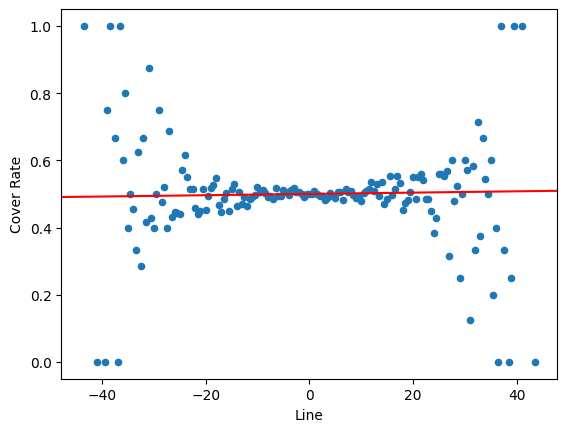

In [14]:
historical_ats_df.plot(x='Line', y='Cover Rate', kind='scatter')
plt.axline((0, c), slope = m, color="red")

In [15]:
historical_ats_df['Regressed Cover Prob'] = historical_ats_df['Line'] * m + c

In [16]:
# m = historical_ats_df['Games'].mean()
m = 50
v = historical_ats_df['Games']
R = historical_ats_df['Cover Rate']
C = historical_ats_df['Regressed Cover Prob']

historical_ats_df['Bayesian Estimate'] = (v * R) / (v + m) + (m * C) / (v + m)

<Axes: xlabel='Line'>

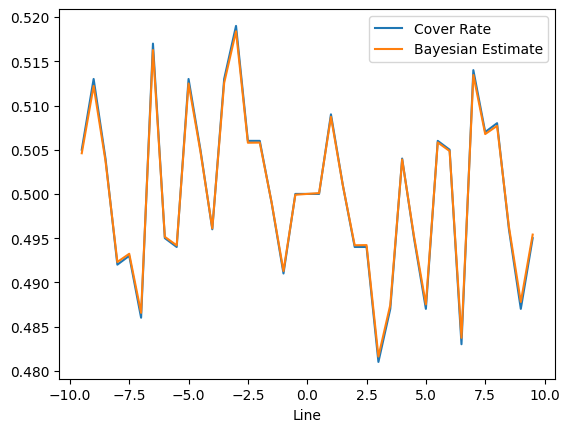

In [17]:
historical_ats_df[historical_ats_df["Line"].abs() < 10].sort_values("Line")[["Line", "Cover Rate", "Bayesian Estimate"]].plot(x="Line")

In [18]:
historical_ats_df["Smoothed Win Rate"] = 1 / (1 + np.power(10, (historical_ats_df['Line']) *30.464/400))

In [19]:
spread_to_histrical_prob = dict(zip(historical_ats_df['Line'], historical_ats_df['Bayesian Estimate'] - historical_ats_df["Smoothed Win Rate"]))

In [20]:
map_fte_to_bovada = {
    "Brigham Young": "BYU",
    "North Carolina State": "NC State",
    "Charleston": "Coll Charleston",
    "Saint Mary's": "Saint Mary's CA",
}
fte_df['team'] = fte_df['team'].replace(map_fte_to_bovada)

In [21]:
merged_df = bovada_df.merge(fte_df, left_on="team", right_on="team", how="left")

In [22]:
merged_df['cover_prob'] = merged_df['prob'] + merged_df['spread_val'].map(spread_to_histrical_prob)

In [23]:
merged_df

,team,bet_name,type,spread_val,odds,prob,cover_prob
0,Alabama,Alabama ML,ML,0.0,6.000000,0.20,0.200000
1,Connecticut,Connecticut ML,ML,0.0,1.133333,0.80,0.800000
2,Alabama,Alabama +11.5,Spread,11.5,1.952381,0.20,0.596584
3,Connecticut,Connecticut -11.5,Spread,-11.5,1.870000,0.80,0.403416
4,Alabama,Alabama +9.5,Spread,9.5,2.250000,0.20,0.536438
5,Connecticut,Connecticut -9.5,Spread,-9.5,1.606061,0.80,0.463562
6,Alabama,Alabama +10.0,Spread,10.0,2.150000,0.20,0.531839
7,Connecticut,Connecticut -10.0,Spread,-10.0,1.666667,0.80,0.468161
8,Alabama,Alabama +10.5,Spread,10.5,2.100000,0.20,0.566979
9,Connecticut,Connecticut -10.5,Spread,-10.5,1.690000,0.80,0.433021


In [24]:
merged_df['prob'] = merged_df['prob'].where(merged_df['type'] == "ML", other=merged_df['cover_prob'])

In [25]:
merged_df["kc"] = merged_df["prob"] - ((1 - merged_df["prob"]) / (merged_df["odds"] - 1))

prob = merged_df["prob"]
wager_amt = np.maximum(0, merged_df["kc"])
net_odds = merged_df["odds"] - 1
not_prob = 1 - prob

merged_df["log_ev"] = merged_df["prob"] * np.log(1 + wager_amt * net_odds) + not_prob * np.log(1-wager_amt)

In [26]:
merged_df[merged_df["kc"] > 0][["bet_name", "odds", "prob", "log_ev"]].style.hide(axis="index")

bet_name,odds,prob,log_ev
Alabama ML,6.000000,0.200000,0.003807
Alabama +11.5,1.952381,0.596584,0.014360
Alabama +9.5,2.250000,0.536438,0.017000
Alabama +10.0,2.150000,0.531839,0.008918
Alabama +10.5,2.100000,0.566979,0.016518
Alabama +11.0,2.000000,0.580737,0.013094
Alabama +12.0,1.833333,0.623856,0.012570
Alabama +12.5,1.769230,0.607995,0.003756
Alabama +13.0,1.690000,0.634990,0.003924
Purdue ML,1.196078,0.840000,0.000057


In [27]:
rec_bets = merged_df.loc[merged_df[merged_df["kc"] > 0].groupby('team')['log_ev'].idxmax()]

In [28]:
rec_bets[["bet_name", "odds", "prob"]].sort_index().style.hide(axis="index")

bet_name,odds,prob
Alabama +9.5,2.250000,0.536438
Purdue -10.0,2.000000,0.508161


In [29]:
merged_df[(merged_df["kc"] > 0) & (merged_df["type"] == "ML")][["bet_name", "odds", "prob"]].style.hide(axis="index")

bet_name,odds,prob
Alabama ML,6.000000,0.200000
Purdue ML,1.196078,0.840000


In [30]:
merged_df

,team,bet_name,type,spread_val,odds,prob,cover_prob,kc,log_ev
0,Alabama,Alabama ML,ML,0.0,6.000000,0.200000,0.200000,0.040000,0.003807
1,Connecticut,Connecticut ML,ML,0.0,1.133333,0.800000,0.800000,-0.700004,0.000000
2,Alabama,Alabama +11.5,Spread,11.5,1.952381,0.596584,0.596584,0.172998,0.014360
3,Connecticut,Connecticut -11.5,Spread,-11.5,1.870000,0.403416,0.403416,-0.282313,0.000000
4,Alabama,Alabama +9.5,Spread,9.5,2.250000,0.536438,0.536438,0.165588,0.017000
5,Connecticut,Connecticut -9.5,Spread,-9.5,1.606061,0.463562,0.463562,-0.421559,0.000000
6,Alabama,Alabama +10.0,Spread,10.0,2.150000,0.531839,0.531839,0.124742,0.008918
7,Connecticut,Connecticut -10.0,Spread,-10.0,1.666667,0.468161,0.468161,-0.329597,0.000000
8,Alabama,Alabama +10.5,Spread,10.5,2.100000,0.566979,0.566979,0.173324,0.016518
9,Connecticut,Connecticut -10.5,Spread,-10.5,1.690000,0.433021,0.433021,-0.388688,0.000000
